In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preprocess import any_null_col, add_coordinates
import seaborn as sns
from sklearn.model_selection import GroupKFold


pd.options.display.max_columns = 999
random_state = 39

In [2]:
df = pd.read_csv('../../CSGO/mm_master_demos.csv')
df = df.sample(frac=0.1, random_state=random_state)
df = df.drop(['Unnamed: 0', 'file'], axis=1).reset_index(drop=True)
## rank = 0 means the player does not play competitive games
df = df[df['att_rank'] != 0]
df.head()

,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted,bomb_site,hitbox,wp,wp_type,award,winner_team,winner_side,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,de_mirage,09/28/2017 8:47:23 PM,12,74000,1156.781,Team 1,Team 1,CounterTerrorist,CounterTerrorist,14,0,False,NaN,RightLeg,Deagle,Pistol,300,Team 1,CounterTerrorist,76561198129930965,9,76561198178182678,8,-1529.5890,-2167.3310,-1383.3080,-2279.8580,ECO,30300,7600,8.0
1,de_inferno,09/28/2017 8:56:01 PM,26,177767,2778.144,Team 1,Team 2,Terrorist,CounterTerrorist,27,3,False,NaN,Chest,AK47,Rifle,300,Team 2,CounterTerrorist,76561198049586514,18,76561198156184266,16,69.5624,1087.1110,102.3935,1552.7860,NORMAL,29850,26300,16.0
2,de_inferno,09/20/2017 10:30:05 AM,20,141194,2206.730,Team 1,Team 2,Terrorist,CounterTerrorist,74,15,False,NaN,Head,AK47,Rifle,300,Team 1,Terrorist,76561198004222916,13,76561198073770861,12,1468.1990,151.8160,2543.7320,-84.7408,NORMAL,18300,20500,13.0
3,de_mirage,09/28/2017 9:40:01 PM,21,142943,2234.041,Team 2,Team 1,CounterTerrorist,Terrorist,14,1,False,NaN,Stomach,XM1014,Heavy,900,Team 2,CounterTerrorist,76561198068609350,9,76561198249015896,8,-1416.3320,263.4925,-1833.6930,295.7267,NORMAL,23150,16350,9.0
4,de_mirage,09/28/2017 9:17:15 PM,20,115935,1811.975,Team 1,Team 2,Terrorist,CounterTerrorist,26,1,False,NaN,Stomach,Tec9,Pistol,300,Team 2,CounterTerrorist,76561198262727977,15,76561198305235533,16,-1661.8430,827.7089,-2377.0640,710.0730,ECO,30100,4300,15.0


In [3]:
### Checks if df has null values
if_null = any_null_col(df)

Columns containing null values: ['bomb_site'] with null ratios: [0.847]


In [4]:
### many rows have null values for 'bomb_site' because is the bomb is not planted, i.e. is_bomb_planted = False, there is no bomb_site
# verification:
np.mean(df['is_bomb_planted'] == False) == np.mean(df['bomb_site'].isnull())

True

#### Target Variable: att_rank
- att_rank is an ordinal variable indicating players' ranks from 1 to 18
- att_rank = 0 is dropped from dataframe since we are only interested in players who has a rank
- att_rank: the rank for the attacker

There is only 0.014% of players at rank 1, i.e. only 13 out of 93391 players.


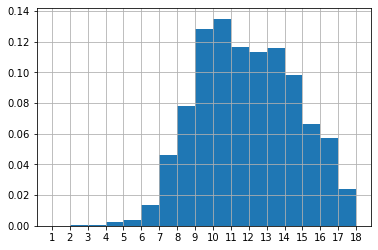

In [5]:
### target variable
# distribution
# it is difficult to get very good, yet it's also very hard to stay very bad 
target = 'att_rank'
df[target].hist(bins=df[target].nunique()-1, density=True)
plt.xticks(range(1, 19))
rank_1_n = np.sum(df[target] == 1)
rank_1_percent = np.round(np.mean(df[target] == 1) * 100, 3)
print('There is only {}% of players at rank 1, i.e. only {} out of {} players.'.format(rank_1_percent, rank_1_n, df.shape[0]))

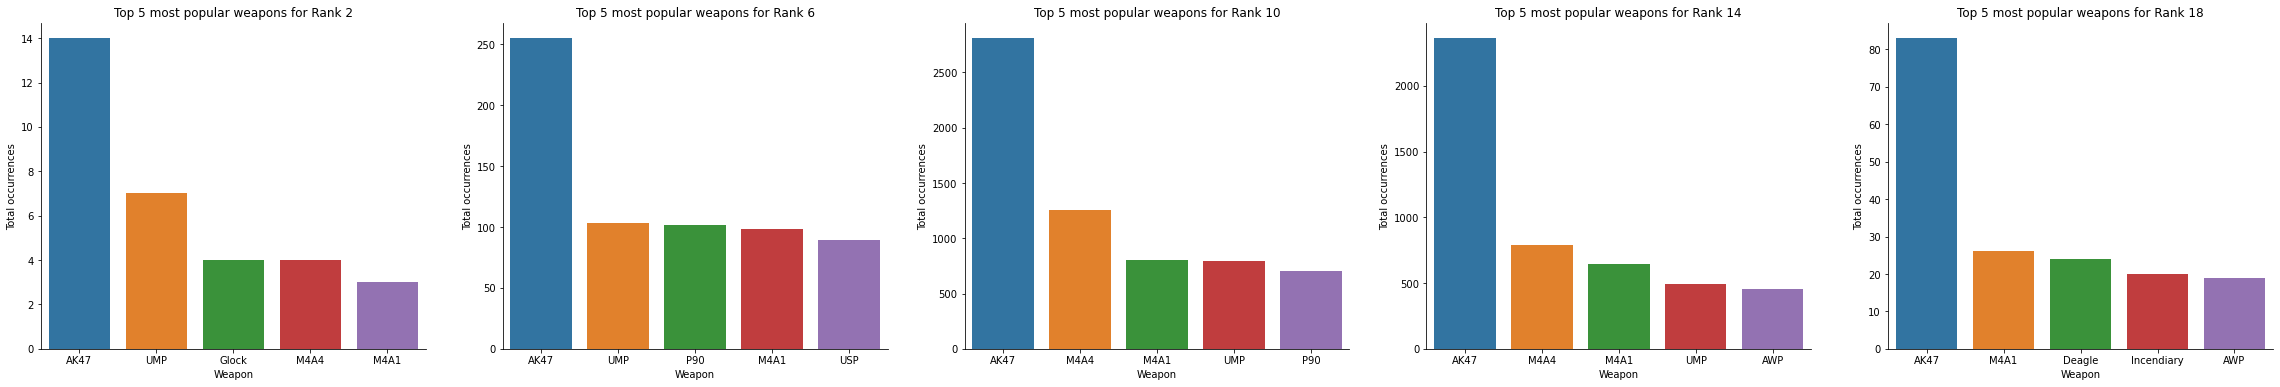

In [6]:
wp_ranks = [2, 6, 10, 14, 18]
n_top_wp = 5
fig, ax = plt.subplots(1, len(wp_ranks), figsize=(40, 6))
for i in range(len(wp_ranks)):
    top_5_weaps = df[df['att_rank'] == wp_ranks[i]]['wp'].value_counts().head(n_top_wp)

    sns.barplot(ax=ax[i], x=top_5_weaps.index, y=top_5_weaps.values)
    ax[i].set_xlabel('Weapon')
    ax[i].set_ylabel('Total occurrences')
    ax[i].set_title('Top {} most popular weapons for Rank {}'.format(n_top_wp, wp_ranks[i]))


sns.despine()



/Users/haibo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/haibo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/haibo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.w

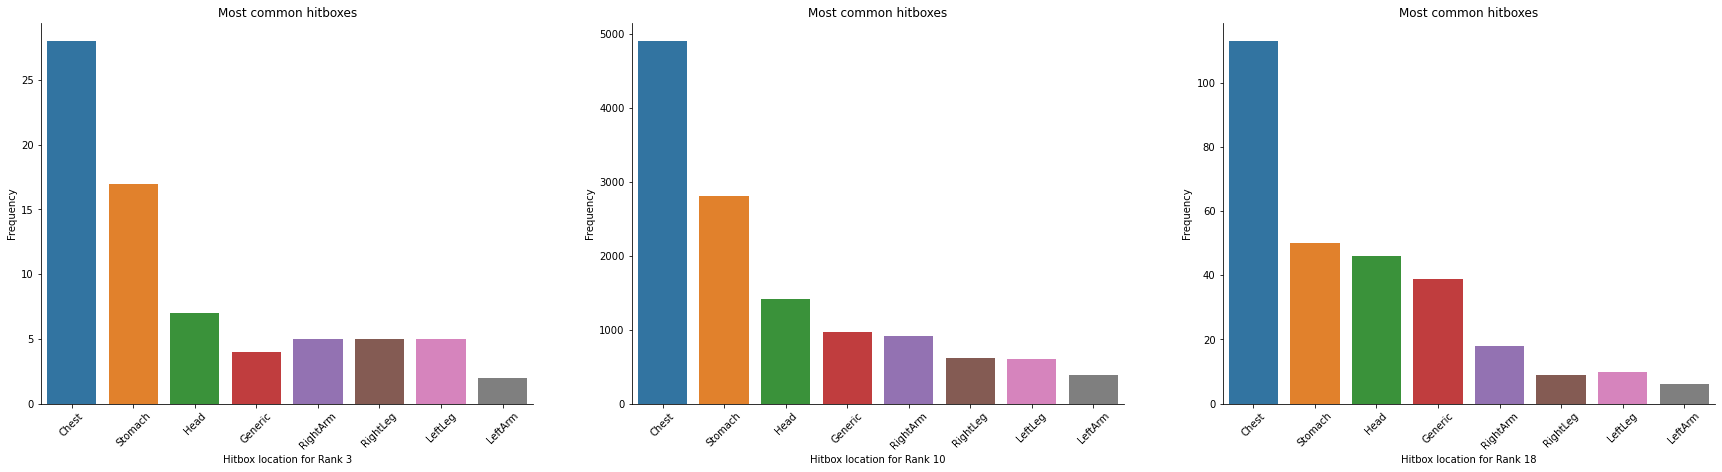

In [7]:
hit_box_ranks = [3, 10, 18]
fig, ax = plt.subplots(1, len(hit_box_ranks), figsize=(30, 7))
for i in range(len(hit_box_ranks)):
    
    g = sns.countplot(df[df['att_rank'] == hit_box_ranks[i]]['hitbox'], ax=ax[i], order=df['hitbox'].value_counts().index)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    ax[i].set_xlabel('Hitbox location for Rank {}'.format(hit_box_ranks[i]))
    ax[i].set_ylabel('Frequency')
    ax[i].set_title('Most common hitboxes')
sns.despine();


## TODO: hitbox for different weapons!!!!

In [62]:
map_data = pd.read_csv('../../CSGO/map_data.csv', index_col=0)
map_data.loc['de_overpass'] = {'StartX': -4820, 'StartY': -3591, 'EndX': 503, 'EndY': 1740, 'ResX': 1024, 'ResY': 1024}
map_data.loc['de_nuke'] = {'StartX': -3082, 'StartY': -4464, 'EndX': 3516, 'EndY': 2180, 'ResX': 1024, 'ResY': 1024}
df_ = pd.read_csv('../../CSGO/mm_master_demos.csv')
df_ = df_.drop(['Unnamed: 0', 'file'], axis=1).reset_index(drop=True)
## rank = 0 means the player does not play competitive games
df_ = df_[df_['att_rank'] != 0]

add_coordinates(df_, map_data)

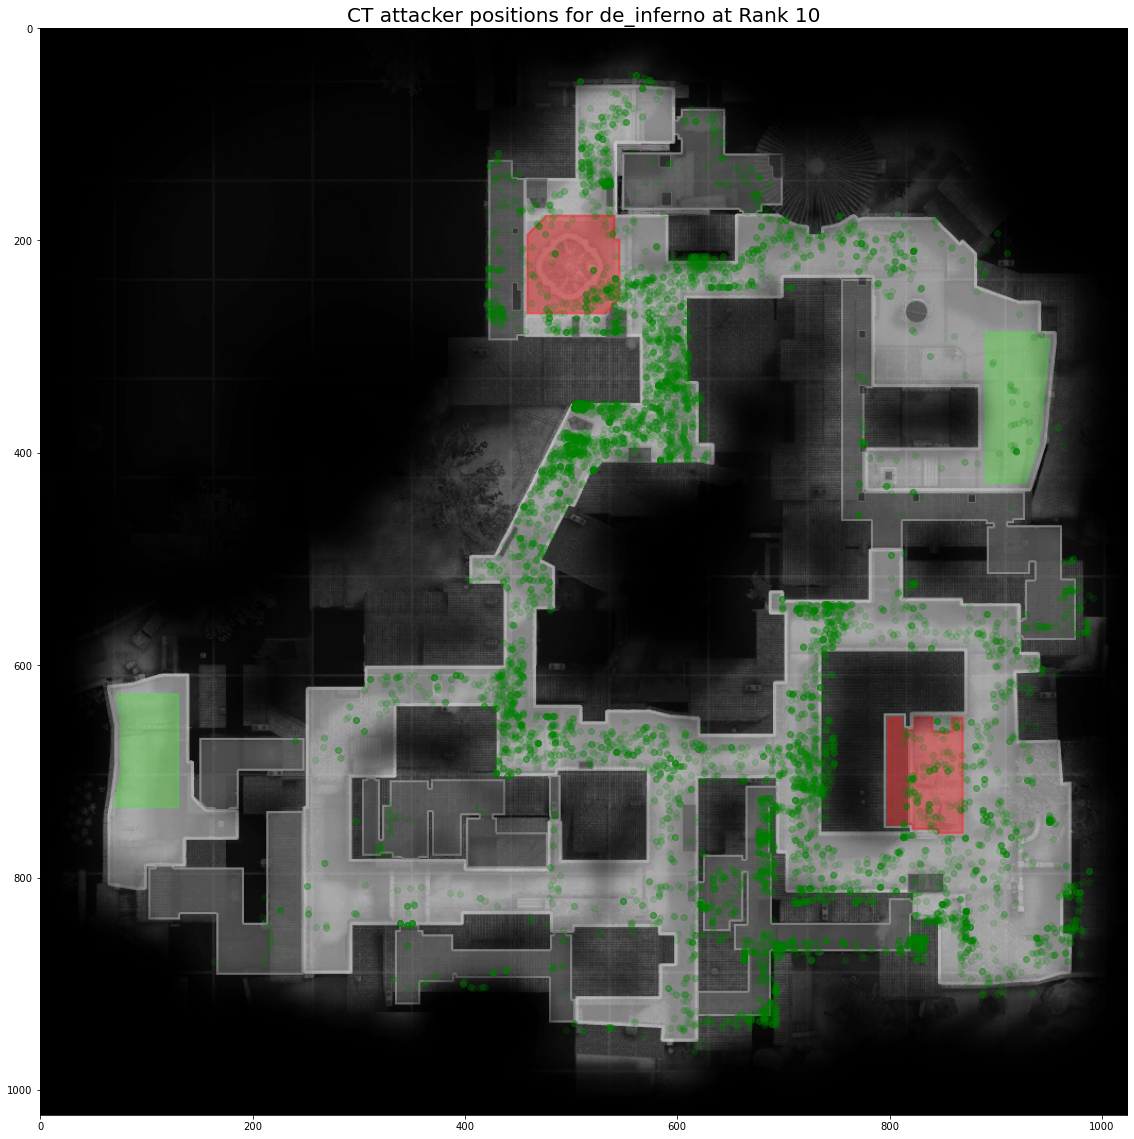

In [177]:
map_name = 'de_inferno'
map_rank = 10
CT = 'CounterTerrorist'
T = 'Terrorist'

map_data = df_.loc[(df_['map'] == map_name) & (df_['att_rank'] == map_rank) & (df_['att_side'] == CT)]
# map_data = df.loc[df['map'] == map_name]
# map_data = df_.loc[(df_['map'] == map_name) & (df_['att_rank'] == map_rank)]



# Plot attack positions.
plt.figure(figsize=(20, 20))
plt.imshow(plt.imread(f'../images/{map_name}_.png'))
plt.scatter(map_data['AttackPosX'], map_data['AttackPosY'], alpha=0.15, c='green')
plt.title(f'CT attacker positions for {map_name} at Rank {map_rank}', fontsize=20)
plt.show()

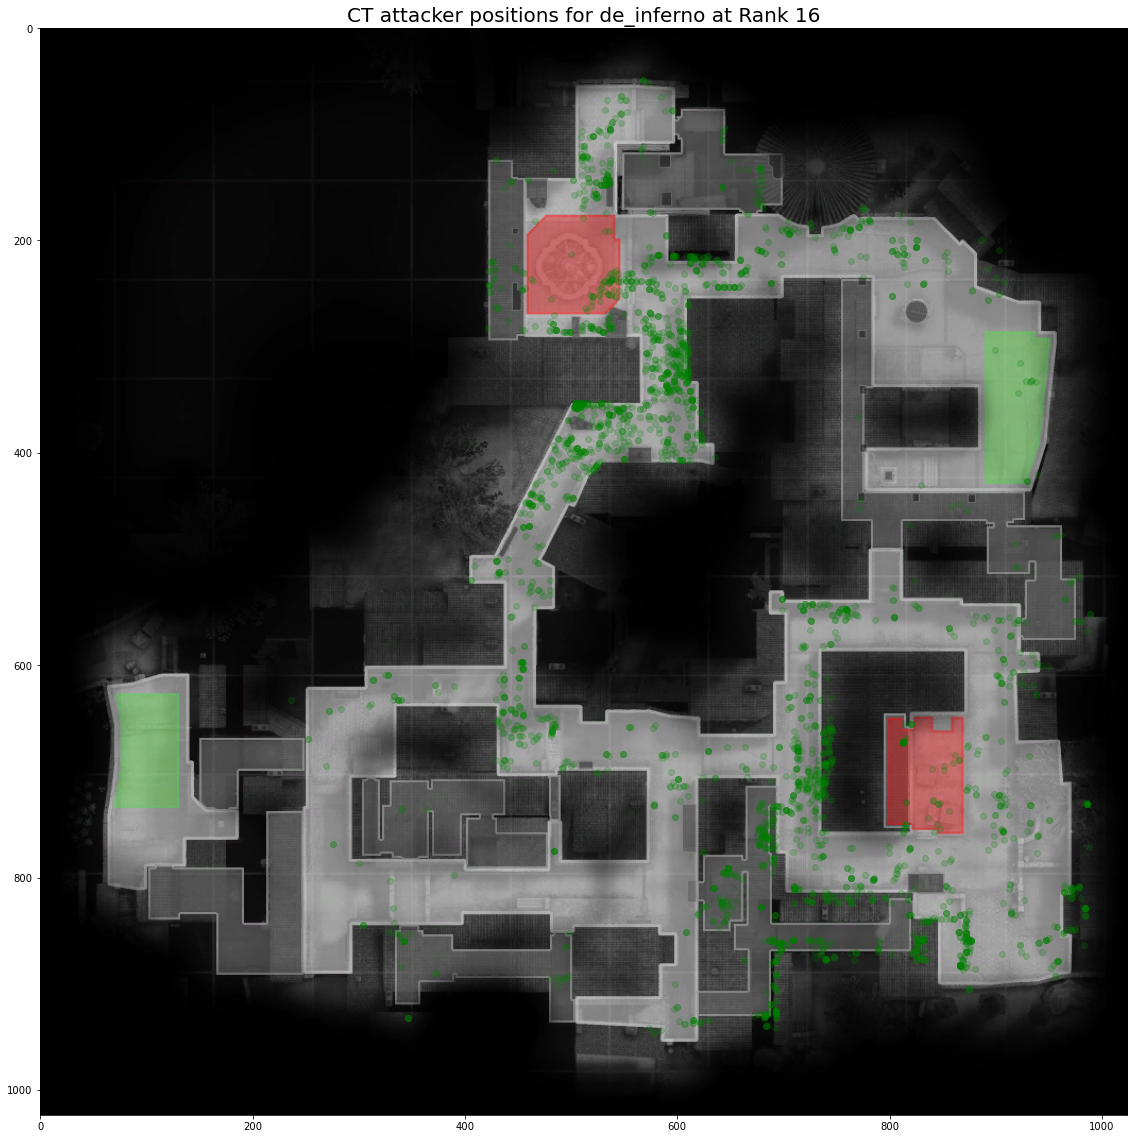

In [176]:
map_name = 'de_inferno'
map_rank = 16
CT = 'CounterTerrorist'
T = 'Terrorist'

map_data = df_.loc[(df_['map'] == map_name) & (df_['att_rank'] == map_rank) & (df_['att_side'] == CT)]
# map_data = df.loc[df['map'] == map_name]
# map_data = df_.loc[(df_['map'] == map_name) & (df_['att_rank'] == map_rank)]



# Plot attack positions.
plt.figure(figsize=(20, 20))
plt.imshow(plt.imread(f'../images/{map_name}_.png'))
plt.scatter(map_data['AttackPosX'], map_data['AttackPosY'], alpha=0.2, c='green')
plt.title(f'CT attacker positions for {map_name} at Rank {map_rank}', fontsize=20)
plt.show()

In [178]:
df.head()

,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted,bomb_site,hitbox,wp,wp_type,award,winner_team,winner_side,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank,AttackPosX,AttackPosY
0,de_mirage,09/28/2017 8:47:23 PM,12,74000,1156.781,Team 1,Team 1,CounterTerrorist,CounterTerrorist,14,0,False,NaN,RightLeg,Deagle,Pistol,300,Team 1,CounterTerrorist,76561198129930965,9,76561198178182678,8,-1529.5890,-2167.3310,-1383.3080,-2279.8580,ECO,30300,7600,8.0,336.0,776.0
1,de_inferno,09/28/2017 8:56:01 PM,26,177767,2778.144,Team 1,Team 2,Terrorist,CounterTerrorist,27,3,False,NaN,Chest,AK47,Rifle,300,Team 2,CounterTerrorist,76561198049586514,18,76561198156184266,16,69.5624,1087.1110,102.3935,1552.7860,NORMAL,29850,26300,16.0,436.0,572.0
2,de_inferno,09/20/2017 10:30:05 AM,20,141194,2206.730,Team 1,Team 2,Terrorist,CounterTerrorist,74,15,False,NaN,Head,AK47,Rifle,300,Team 1,Terrorist,76561198004222916,13,76561198073770861,12,1468.1990,151.8160,2543.7320,-84.7408,NORMAL,18300,20500,13.0,737.0,769.0
3,de_mirage,09/28/2017 9:40:01 PM,21,142943,2234.041,Team 2,Team 1,CounterTerrorist,Terrorist,14,1,False,NaN,Stomach,XM1014,Heavy,900,Team 2,CounterTerrorist,76561198068609350,9,76561198249015896,8,-1416.3320,263.4925,-1833.6930,295.7267,NORMAL,23150,16350,9.0,359.0,286.0
4,de_mirage,09/28/2017 9:17:15 PM,20,115935,1811.975,Team 1,Team 2,Terrorist,CounterTerrorist,26,1,False,NaN,Stomach,Tec9,Pistol,300,Team 2,CounterTerrorist,76561198262727977,15,76561198305235533,16,-1661.8430,827.7089,-2377.0640,710.0730,ECO,30100,4300,15.0,310.0,173.0
